# Compression Anonymity

This notebook explores several avenues of using compression and common compression schemes to provide anonymity and privacy. First, we'll write a simple implementation of Huffman encoding, but make it generic enough so that it can be tweaked to provide privacy instead of compression.

# Preliminaries

Before writing any code for privacy, we'll need the basic data structures and building blocks we're going to use throughout this notebook to write the compression algorithms.

## Utility Functions

In [1]:
import Data.Coerce

ala :: Coercible a b => (b -> b -> b) -> (a -> b) -> a -> a -> a
ala f _ = coerce f

## A Binary Tree

This is the Tree we'll use for both the encoding and anonymization algorithms. It stores some measure for its subtrees (in Huffman encoding, this will simply be the count).

In [2]:
:ext DeriveFoldable

import Data.Semigroup.Foldable (Foldable1(foldMap1))
import Data.Semigroup          ((<>))

data Tree a b
    = Leaf { measure :: a
           , val     :: b }
    | Node { measure :: a
           , lchild  :: Tree a b
           , rchild  :: Tree a b }
    deriving Foldable

instance Foldable1 (Tree a) where
    foldMap1 f (Leaf _ x) = f x
    foldMap1 f (Node _ l r) = foldMap1 f l <> foldMap1 f r

We can draw the tree, with the counts of subtrees at each node:

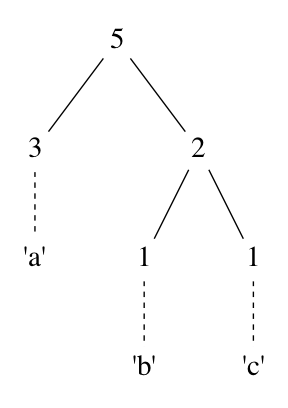

In [3]:
:ext FlexibleContexts

import           Diagrams.TwoD.Layout.Tree (renderTree',symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc,lc
                                           ,white,pad,centerXY,(~~),(#)
                                           ,dashingG)
import           IHaskell.Display          (IHaskellDisplay(display))
import qualified Data.Tree                 as Rose
import           Data.Semigroup            ((<>))

instance (Show a, Show b) => IHaskellDisplay (Tree a b) where
    display = display . diagram . drawTree . toTree
      where
        toTree (Leaf i x)
            = Rose.Node (True,show i) [Rose.Node (False,show x) []]
        toTree (Node i l r)
            = Rose.Node (True,show i) [toTree l, toTree r]
        renderNode n = text n # fontSizeL 0.2
                    <> circle 0.2 # fc white # lc white
        renderBranch (_,l) (vr,r)
          | fst vr = l ~~ r
          | otherwise = l ~~ r 
                      # dashingG [0.05, 0.05] 0
        drawTree
            = pad 1.1
            . centerXY
            . renderTree' (renderNode . snd) renderBranch
            . symmLayout

Node 5 (Leaf 3 'a') (Node 2 (Leaf 1 'b') (Leaf 1 'c'))

Then, we'll need some machinery for translating between codes and trees.

In [4]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map
import           Data.Semigroup  (Semigroup((<>)))

type Code = [Bool]

foldMapWithCode :: Semigroup m => (Code -> b -> m) -> Tree a b -> m
foldMapWithCode f (Leaf _ x) = f [] x
foldMapWithCode f (Node _ xs ys)
    =  foldMapWithCode (f . (:) False) xs
    <> foldMapWithCode (f . (:) True) ys 

codeBook :: Ord b => Tree a b -> Map b Code
codeBook = foldMapWithCode (flip Map.singleton)

## A Priority Queue

A pairing heap <cite data-cite="2201627/9H95638W"></cite> is simple to implement, and works well as a priority queue. Both the `<>` and `insertHeap` functions below are amortized $\mathcal{O}(1)$, and `minView` is amortized $\mathcal{O}(\log n)$.

In [5]:
import Data.Semigroup (Semigroup((<>)))

data Heap a b = Heap a b [Heap a b]

instance Ord a => Semigroup (Heap a b) where
    Heap i x xs <> Heap j y ys
      | i <= j = Heap i x (Heap j y ys : xs)
      | otherwise = Heap j y (Heap i x xs : ys)

minView :: Ord a => Heap a b -> (a, b, Maybe (Heap a b))
minView (Heap i x xs) = (i, x, case xs of
    [] -> Nothing
    (y:ys) -> Just (mergeHeaps y ys))
  where
    mergeHeaps t []          = t
    mergeHeaps t1 [t2]       = t1 <> t2
    mergeHeaps t1 (t2:t3:ts) = (t1 <> t2) <> mergeHeaps t3 ts

insertHeap :: Ord a => a -> b -> Heap a b -> Heap a b
insertHeap i x (Heap j y ys)
  | i <= j = Heap i x [Heap j y ys]
  | otherwise = Heap j y (Heap i x [] : ys)

## A Measure Table

We'll be using Haskell's standard `Map` type, which has $\mathcal{O}(\log n)$ update, delete, etc. Building a frequency table is therefore $\mathcal{O}(n \log n)$.

In [6]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map

import           Data.Foldable   (Foldable(foldMap,foldl'))
import           Data.Semigroup  (Semigroup(..))

newtype MeasureTable a b
    = MeasureTable
    { getMeasures :: Map b a
    }

instance (Semigroup a, Ord b) => Semigroup (MeasureTable a b) where
    MeasureTable xs <> MeasureTable ys
        = MeasureTable (Map.unionWith (<>) xs ys)

instance (Semigroup a, Ord b) => Monoid (MeasureTable a b) where
    mempty = MeasureTable Map.empty
    mappend = (<>)

buildMeasureTable :: (Foldable f, Semigroup a, Ord b)
                  => (b -> a) -> f b -> MeasureTable a b
buildMeasureTable f = foldMap (\x -> MeasureTable (Map.singleton x (f x)))

instance Integral a => Foldable (MeasureTable a) where
    foldMap f (MeasureTable xs) =
        Map.foldMapWithKey (rep . f) xs
      where
        rep x 1 = x
        rep x n
          | even n = mappend y y
          | otherwise = mappend x (mappend y y)
          where y = rep x (n `div` 2)

A frequency table is simply the measure table specialized to $\mathbb{N}$.

In [7]:
import Numeric.Natural
import Data.Semigroup (Sum(..))

type Frequencies = MeasureTable (Sum Natural)

buildFrequencies :: (Ord a, Foldable f) => f a -> Frequencies a
buildFrequencies = buildMeasureTable (const 1)

We can plot the contents of a frequency table using a histogram.

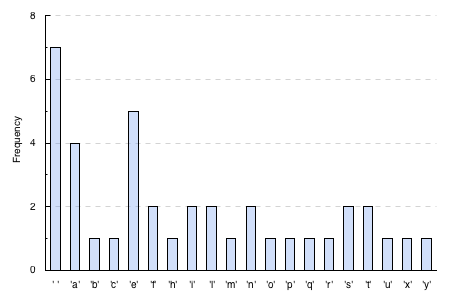

In [8]:
:ext StandaloneDeriving
:ext GeneralizedNewtypeDeriving
:ext RankNTypes

import Graphics.Rendering.Chart (layout_x_axis,laxis_generate
                                ,layout_y_axis,toRenderable,autoIndexAxis
                                ,laxis_title,layout_plots,plotBars
                                ,plot_bars_values,addIndexes
                                ,plot_bars_item_styles,fill_color
                                ,PlotValue(..),BarsPlotValue(..),AxisFn
                                ,AxisData(..))
import Data.Colour              (withOpacity)
import Data.Colour.Names        (cornflowerblue)
import Data.Default.Class       (def)
import Control.Lens             (Iso',(^.),iso,mapping,from,(.~),lmapping
                                ,rmapping,dimapping,firsting,each,_1,enum)
import IHaskell.Display         (IHaskellDisplay(display))
import Data.Profunctor

onAxisData :: Iso' a b -> Iso' (AxisFn a) (AxisFn b)
onAxisData l
    = dimapping
        (mapping (from l))
        (iso (dataChange l) (dataChange (from l)))
  where
    dataChange l (AxisData vs vp tv tc lb gd)
        = AxisData
            vs
            (vp ^. (rmapping.lmapping.from) l)
            (tv ^. (rmapping.rmapping) l)
            (tc ^. (mapping.firsting) l)
            (lb ^. (mapping.mapping.firsting) l)
            (gd ^. mapping l)

instance PlotValue Natural where
    toValue = fromIntegral
    fromValue = round
    autoAxis = autoAxis ^. onAxisData enum

instance BarsPlotValue Natural where
    barsReference = 0
    barsAdd = (+)

deriving instance PlotValue a => PlotValue (Sum a)
deriving instance BarsPlotValue a => BarsPlotValue (Sum a)

instance (Show b, Ord a, BarsPlotValue a)
        => IHaskellDisplay (MeasureTable a b) where
    display (MeasureTable freqs)
        = display
        $ toRenderable
        $ layout_x_axis.laxis_generate .~ autoIndexAxis keys
        $ layout_y_axis.laxis_title .~ "Frequency"
        $ layout_plots .~ [ plotBars
                          $ plot_bars_values .~ addIndexes vals
                          $ plot_bars_item_styles.each._1.fill_color .~
                                cornflowerblue `withOpacity` 0.3
                          $ def ]
        $ def
      where
        (keys,vals) = unzip [ (show k, [v]) | (k,v) <- Map.toList freqs ]

:opt svg

display $ buildFrequencies "this is an example of a frequency table"

## Rendering Histograms

We'll also need an easy way to show a histogram of continuous data.

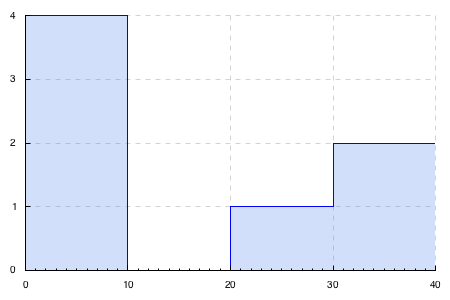

In [9]:
import Graphics.Rendering.Chart                (PlotValue,Renderable
                                               ,Layout,toRenderable
                                               ,fill_color)
import Graphics.Rendering.Chart.Plot.Histogram (histToPlot
                                               ,plot_hist_values
                                               ,plot_hist_bins
                                               ,plot_hist_range
                                               ,plot_hist_fill_style)
import Data.Colour                             (withOpacity)
import Data.Colour.Names                       (cornflowerblue)
import Data.Default.Class                      (def)
import Control.Lens                            ((.~))

histogram :: (Ord a, RealFrac a, PlotValue a)
          => a -> a -> [a] -> Renderable ()
histogram binSize lowerBound values =
    toRenderable
  $ layout_plots .~ [ histToPlot 
                    $ plot_hist_values .~ values
                    $ plot_hist_bins .~ bins
                    $ plot_hist_range .~
                        Just (lowerBound
                             ,lowerBound + fromIntegral bins * binSize)
                    $ plot_hist_fill_style . fill_color .~
                        cornflowerblue `withOpacity` 0.3
                    $ def ]
  $ (def :: PlotValue a => Layout a Int)
  where
    bins = ceiling ((maximum values - lowerBound) / binSize)

histogram 10 0 [6,2,3,1,36,38,27]

## Ranges

One of the fundamental ways we'll be using to summarize data is with a range. We can encode that as so:

In [10]:
import Data.Semigroup      (Semigroup(..),Option(..),Max(..),Min(..))
import Control.Applicative (liftA2)
import Text.Printf         (printf,PrintfArg)
import Data.Maybe          (fromMaybe,fromJust)

data Range a
    = Range
    { lowerBound :: Maybe a
    , upperBound :: Maybe a
    } deriving (Eq,Ord)

instance (Ord a, Enum a, PrintfArg a, Bounded a) => Show (Range a) where
    show (Range (Just l) (Just u))
      | succ l == u = printf "%v" l
      | l >= u = "∅"
    show (Range l (Just u)) = printf "[%v,%v)" (fromMaybe minBound l) u
    show (Range l Nothing)
      | l == Just maxBound = printf "%v" (maxBound `asTypeOf` fromJust l)
      | otherwise =
          printf
              "[%v,%v]"
              (fromMaybe minBound l)
              (maxBound `asTypeOf` fromJust l)

union :: Ord a => Range a -> Range a -> Range a
union (Range xl xu) (Range yl yu)
    = Range
        (liftA2 min xl yl)
        (liftA2 max xu yu)

intersection :: Ord a => Range a -> Range a -> Range a
intersection (Range lx ux) (Range ly uy)
    = Range
        (((<>) `ala` (Option . fmap Max)) lx ly)
        (((<>) `ala` (Option . fmap Min)) ux uy)

instance Ord a => Semigroup (Range a) where
    (<>) = union

singletonRange :: (Enum a, Bounded a, Eq a) => a -> Range a
singletonRange x
  | x == maxBound = Range (Just x) Nothing
  | otherwise = Range (Just x) (Just (succ x))

# Huffman Encoding

We're now able to write the algorithm for Huffman compression.

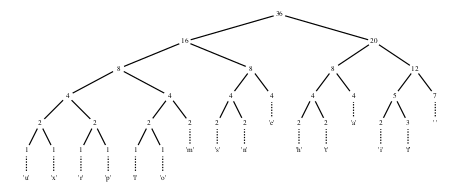

Original,Code
'e',011
'x',00001
'a',101
'm',0011
'p',00011
'l',00100
'e',011


In [11]:
import           Data.Maybe       (fromJust)
import           Data.Semigroup   (Option(..), Semigroup(..))
import           Data.Map.Strict  (Map)
import qualified Data.Map.Strict  as Map
import           IHaskell.Display (Display(..),html)
import           Data.Bool        (bool)

buildHuffman :: (Ord a, Semigroup a) => Heap a (Tree a b) -> Tree a b
buildHuffman hp = case minView hp of
    (_,x,Nothing) -> x
    (i,x,Just xs) -> case minView xs of
        (j,y,Nothing) -> Node (i <> j) x y
        (j,y,Just ys) ->
            buildHuffman (insertHeap (i <> j) (Node (i <> j) x y) ys)

buildHeap :: Ord a => MeasureTable a b -> Heap a (Tree a b)
buildHeap
    = fromJust
    . getOption
    . Map.foldMapWithKey (\v i -> Option (Just (Heap i (Leaf i v) [])))
    . getMeasures

huffmanTree :: Ord a => [a] -> Tree Natural a
huffmanTree = coerce . buildHuffman . buildHeap . buildFrequencies

tree = huffmanTree "this is an example of a huffman tree"
tree

data HuffmanTable a
    = HuffmanTable
    { huffmanTableVals :: [a]
    , huffmanTableCode :: [Code]
    }

buildHuffmanTable :: Ord a => Tree c a -> [a] -> HuffmanTable a
buildHuffmanTable tr xs = HuffmanTable xs (map (mp Map.!) xs)
  where
    mp = codeBook tr

instance Show a => IHaskellDisplay (HuffmanTable a) where
    display (HuffmanTable xs ys) = pure (Display [html go])
      where
        go
            = unlines $
            [ "<table>"
            , "<tr><th>Original</th><th>Code</th></tr>" ] ++
            zipWith tr xs ys ++
            [ "</table>" ]
        tr orig code
            = concat 
            [ "<tr><td style=\"text-align: center;\">"
            , show orig
            , "</td><td><pre style=\"text-align: left;\">"
            , map (bool '0' '1') code
            , "</pre></td></tr>" ]

buildHuffmanTable tree "example"

## Huffman Anonymity

Huffman compression has a ready analogue in the form of $k$-anonymity <cite data-cite="2201627/S5ZJQFX5"></cite>. By truncating the output of the Huffman compression, rows which occur fewer than $k$ times are not specified: instead, a prefix (which could correspond to some $n$ rows, $n \geq k$) is provided.

Taken from a different perspective, we build a Huffman tree from the rows in our database. Then, for each value in the database, we walk down the tree from root to the corresponding leaf, stopping if we hit a node that contains fewer than $k$ entries. Then, we output the summary of values at that point.

This general procedure forms the basis for several of the anonymization algorithms.

First, for data, let's use ages:

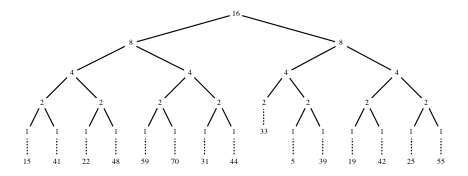

In [12]:
default (Int,Double)

ages :: [Int]
ages = [5,15,19,22,25,33,33,39,31,44,41,42,48,55,59,70]

huffmanTree ages

Finally, we can draw the tree in its private form.

In [13]:
import           Diagrams.TwoD.Layout.Tree (renderTree',symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~),opacity,bg)
import           IHaskell.Display          (IHaskellDisplay(display)
                                           ,latex,Display(ManyDisplay))
import qualified Data.Tree                 as Rose
import           Data.Semigroup            (Semigroup(..))
import           Data.Semigroup.Foldable   (foldMap1)

data PrivateHuffman a b
    = PrivateHuffman
    { kval :: Int
    , generalize :: a -> b
    , tree :: Tree a
    }

instance (Show a, Semigroup b, Show b)
        => IHaskellDisplay (PrivateHuffman a b) where
    display (PrivateHuffman k f tr) = 
        fmap (Display [ latex ("$k = " ++ show k ++ "$") ] <>)
                    (display $ diagram $ bg white $ drawTree $ toTree tr)
      where
        toTree (Leaf i x) =
            Rose.Node (i < k, show i) [Rose.Node (i < k, show x) []]
        toTree (Node i l r)
          | size l >= k && size r >= k =
               Rose.Node (i < k, show i) [toTree l, toTree r]
          | otherwise =
              Rose.Node (i < k, show i)
                  [ Rose.Node (i < k, show (foldMap1 f l <> foldMap1 f r))
                        [ toHiddenTree l, toHiddenTree r ] ]
                        
        toHiddenTree (Node i l r) =
            Rose.Node (True,show i)
                [toHiddenTree l, toHiddenTree r]
        toHiddenTree (Leaf i x) =
            Rose.Node (True,show i)
                [Rose.Node (True, show x) []]

        drawTree
            = pad 1.1
            . centerXY
            . renderTree'
                (\(b,n) -> text n # fontSizeL 0.2 # maybeOp b
                        <> circle 0.2 # fc white # lc white)
                (\((lb,_),ll) ((rb,_),rr) -> maybeOp (lb||rb) (ll ~~ rr))
            . symmLayout
        maybeOp False = id
        maybeOp True  = opacity 0.5

<interactive>:5:15: error:
    • Expecting one more argument to ‘Tree a’
      Expected a type, but ‘Tree a’ has kind ‘* -> *’
    • In the type ‘Tree a’
      In the definition of data constructor ‘PrivateHuffman’
      In the data declaration for ‘PrivateHuffman’

Using this, we can see the immediate problem with Huffman encoding for anonymity:

In [14]:
k2ages = PrivateHuffman 2 singletonRange
    (buildHuffman (buildHeap (buildFrequencies ages)))

k2ages

<interactive>:1:10: error: Data constructor not in scope: PrivateHuffman :: Int -> (Int -> Range Int) -> Tree (Sum Natural) Int -> t

Ages are grouped together with values that are unrelated, yielding unsatisfactory generalizations. The anonymization produced is as follows:

In [15]:
import qualified Data.Map.Strict         as Map
import           Data.Semigroup          (Semigroup(..))
import           Data.Semigroup.Foldable (foldMap1)
import           Data.Foldable           (foldl')
import           IHaskell.Display        (IHaskellDisplay(display)
                                         ,html,Display)
import           Text.Printf             (printf)

newtype AnonTable a b
    = AnonTable
    { getAnonTable :: [(a,b)]
    }

buildAnonTable :: (Ord a, Semigroup b)
               => PrivateHuffman a b -> [a] -> AnonTable a b
buildAnonTable (PrivateHuffman k f xs)
    = AnonTable . map (\x -> (x, m Map.! x))
  where
    m = go xs
    go (Leaf _ x) = Map.singleton x (f x)
    go nd@(Node i l r)
      | size l >= k && size r >= k = go l <> go r
      | otherwise =
          foldl' (\mp v -> Map.insert v summary mp) Map.empty nd
      where summary = foldMap1 f nd

instance (Show a, Show b) => IHaskellDisplay (AnonTable a b) where
    display (AnonTable xs) = pure (Display [html (go xs)])
      where
        go tb
            = unlines
            $ "<table>"
            : "<tr><th>Original</th><th>Anonymized</th></tr>"
            : map (uncurry row) tb ++
            [ "</table>" ]
        row orig anon
            = concat
            [ "<tr><td style=\"text-align: center;\">"
            , show orig
            , "</td><td style=\"text-align: center;\">"
            , show anon
            , "</td></tr>" ]

buildAnonTable k2ages ages

<interactive>:6:19: error: Not in scope: type constructor or class ‘PrivateHuffman’
<interactive>:7:17: error: Not in scope: data constructor ‘PrivateHuffman’

Better generalizations can be achieved by building an *alphabetic* Huffman tree <cite data-cite="2201627/M35JL7I9"></cite>.

In [16]:
import           Control.Monad.State
import qualified Data.Map.Strict     as Map
import           Data.Foldable       (Foldable(..))

buildAlphHuffman :: Frequencies a -> Tree a
buildAlphHuffman xs = evalState (go c) (Map.toList (getFrequencies xs))
  where
    c = length xs
    go n = do
      (x,i) <- gets head
      if i >= n
        then do
          modify tail
          pure (Leaf i x)
        else do
          let m = n `div` 2
          ls <- go m
          rs <- go (n - size ls)
          pure (Node (size ls + size rs) ls rs)

alphHuffmanTree :: Ord a => [a] -> Tree a
alphHuffmanTree = buildAlphHuffman . buildFrequencies

k2agesAlph =
    PrivateHuffman 2 singletonRange (alphHuffmanTree ages)
k2agesAlph
buildAnonTable k2agesAlph ages

<interactive>:16:36: error:
    • Expecting one more argument to ‘Tree a’
      Expected a type, but ‘Tree a’ has kind ‘* -> *’
    • In the type signature: alphHuffmanTree :: Ord a => [a] -> Tree a
<interactive>:1:38: error:
    • Expecting one more argument to ‘Tree a’
      Expected a type, but ‘Tree a’ has kind ‘* -> *’
    • In the type signature: buildAlphHuffman :: Frequencies a -> Tree a

# Arithmetic Coding for Privacy

Arithmetic coding compresses data by encoding successively smaller and smaller intervals. For our purposes, it has two properties which are desirable:

* It is a streaming algorithm, able to output the encoding for an input symbol once it has been received.
* It parameterizes the notion of a "model": for compression, this allows intelligent prediction of things like "a u is likely to come after a q" (when compressing English text). Commonly, it facilitates the building of a frequency table on the fly. For our purposes, it will both build the frequency table on-the-fly, and potentially allow us to cluster similar data together.

In order to use the algorithm for privacy, we will first emit a sequence of intervals, instead of a single number. This removes the capacity for compression. For instance, for the letters $a,b,c$, the following might be emitted:

$$\frac{1}{3},\frac{1}{3},\frac{1}{3}$$

Secondly, we will use a model that builds a cumulative frequency table on the fly (e.g. with a Fenwick tree). This widens the interval for more frequently occurring symbols.

Thirdly, we will truncate the output of the representation of each interval. In other words, we will widen every interval. The amount we widen by will be the minimum amount to make the interval larger than $\frac{k}{n}$ where $n$ is the number of symbols seen so far.

Finally, we will decompress as we compress, translating the intervals back into the values of the domain we are anonymizing. Because we have truncated the interval, it may span more than one value in our model. This is desired: it will happen only when $k$ is satisfied only through generalization.

As a simple way to demonstrate the algorithm, we will use a perfect binary tree to count the cumulative frequencies:

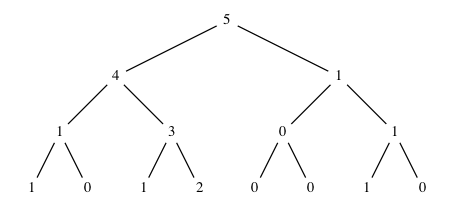

In [17]:
:ext TypeSynonymInstances
:ext FlexibleInstances

import           Data.Bits
import           IHaskell.Display          (IHaskellDisplay(display))
import qualified Data.Tree                 as Rose
import           Diagrams.TwoD.Layout.Tree (renderTree,symmLayout)
import           Diagrams.Prelude          (text,fontSizeL,circle,fc
                                           ,lc,white,pad,centerXY,(#)
                                           ,(~~))
import           Data.Maybe                (catMaybes,fromJust)

data Nested a
    = Perfect !a
    | Nest !(Nested (Branch a))

type Perfect = Nested ()

foldPerfect :: (Word -> b -> Word -> b -> b) -> b -> Perfect -> b
foldPerfect f = go f . const
  where
    go :: (Word -> b -> Word -> b -> b) -> (a -> b) -> Nested a -> b
    go _ b (Perfect x) = b x
    go f b (Nest t) = go f (\(Branch ls l rs r) -> f ls (b l) rs (b r)) t

data Branch a =
    Branch {-# UNPACK #-} !Word
           !a
           {-# UNPACK #-} !Word
           !a

data Span = Span {-# UNPACK #-} !Word {-# UNPACK #-} !Word

instance Show Span where
    showsPrec n (Span l 0) = showsPrec n l
    showsPrec _ (Span l o)
        = showChar '['
        . shows (shiftL l (fromEnum o))
        . showChar ','
        . shows (shiftL (l + 1) (fromEnum o))
        . showChar ')'

makePerfect :: Word -> Perfect
makePerfect = mk ()
  where
    mk :: a -> Word -> Nested a
    mk x 0 = Perfect x
    mk x m = Nest (mk (Branch 0 x 0 x) (m - 1))

incr :: Word -> Perfect -> Perfect
incr i tr = go i 0 tr id
  where
    go :: Word -> Word -> Nested a -> (a -> a) -> Nested a
    go _ _ (Perfect x) c = Perfect (c x)
    go i p (Nest t) c =
        Nest $
        go i (p + 1) t $
            \(Branch sl l sr r) ->
              if testBit i (fromEnum p)
                then Branch sl l (sr + 1) (c r)
                else Branch (sl + 1) (c l) sr r

instance IHaskellDisplay Perfect where
    display = display
            . diagram
            . drawTree
            . res
            . foldPerfect toTree []
      where
        toTree x l y r = [Rose.Node x l, Rose.Node y r]
        res xs = Rose.Node (sum (map Rose.rootLabel xs)) xs
        drawTree
            = pad 1.1
            . centerXY
            . renderTree
                (\n -> text (show n) # fontSizeL 0.2
                    <> circle 0.2 # fc white # lc white)
                (~~)
            . symmLayout
                
foldr incr (makePerfect 3) [0,3,3,2,6]

Then, we can write a function that looks up an item in the tree *up until* the point where $k$ is no longer satisfied:

In [18]:
follow :: Int -> Word -> Perfect -> Span
follow k' i tr = foldPerfect go Span tr 0 k
  where
    k = toEnum k'
    go sl lt sr rt l p
      | sl < k || sr < k = Span l p
      | testBit i (fromEnum p - 1) = rt (shiftL l 1 .|. 1) (p - 1)
      | otherwise = lt (shiftL l 1) (p - 1)

The advantage of this approach is that it maintains $k$-anonymity incrementally. Take, for instance, this small list of values between $0$ and $4$:

In [19]:
smallVals = [1,2,1,3,2,0,1,0,3]

import Data.Traversable (mapAccumL)
import Data.List        (inits)

incrementalAnon :: Int -> Word -> [Word] -> [[Span]]
incrementalAnon k sz xs
    = snd 
    $ mapAccumL
        anon
        (makePerfect sz)
        (zip xs (tail (inits xs)))
  where
    anon tr (v,vs) = (i,traverse (follow k) vs i)
      where
        i = incr v tr

mapM_ print (incrementalAnon 2 2 [1,2,1,3,2,0,1,0,3])

[[0,4)]
[[0,4),[0,4)]
[[0,4),[0,4),[0,4)]
[[0,2),[2,4),[0,2),[2,4)]
[[0,2),[2,4),[0,2),[2,4),[2,4)]
[[0,2),[2,4),[0,2),[2,4),[2,4),[0,2)]
[[0,2),[2,4),[0,2),[2,4),[2,4),[0,2),[0,2)]
[1,[2,4),1,[2,4),[2,4),0,1,0]
[1,2,1,3,2,0,1,0,3]

# Incremental Anonymity

Incrementally anonymizing a database can potentially leak private data <cite data-cite="2201627/HWXFFBRT"></cite>. For instance, take the following values:

In [20]:
incrementalTree = PrivateHuffman 2 singletonRange (alphHuffmanTree [1..5])
incrementalTable = buildAnonTable incrementalTree [1..5]
incrementalTable

<interactive>:1:19: error: Data constructor not in scope: PrivateHuffman :: Int -> (Int -> Range Int) -> t0 -> t
<interactive>:1:52: error:
    • Variable not in scope: alphHuffmanTree :: [Int] -> t0
    • Perhaps you meant ‘huffmanTree’ (line 15)
<interactive>:2:20: error: Variable not in scope: buildAnonTable :: t1 -> [Int] -> t

If another $3$ is added to the database:

In [21]:
nextTree = PrivateHuffman 2 singletonRange (alphHuffmanTree [1,2,3,4,5,3])
nextTable = buildAnonTable nextTree [1,2,3,4,5,3]
nextTable

<interactive>:1:12: error: Data constructor not in scope: PrivateHuffman :: Int -> (Int -> Range Int) -> t0 -> t
<interactive>:1:45: error:
    • Variable not in scope: alphHuffmanTree :: [Int] -> t0
    • Perhaps you meant ‘huffmanTree’ (line 15)
<interactive>:2:13: error: Variable not in scope: buildAnonTable :: t1 -> [Int] -> t

If both of these anonymizations are released, we could take their row-wise intersection, thereby revealing much more information than we intended.

In [22]:
import Data.Function  (on)
import Data.Semigroup (Max(..),Min(..),Option(..),(<>))



AnonTable (zip [1..]
          ((zipWith (intersection `on` snd) `on` getAnonTable)
          incrementalTable nextTable))

<interactive>:1:1: error: Data constructor not in scope: AnonTable :: [(Int, Range Int)] -> t
<interactive>:2:50: error: Variable not in scope: getAnonTable :: a1 -> [(a0, Range Int)]
<interactive>:3:11: error: Variable not in scope: incrementalTable
<interactive>:3:28: error: Variable not in scope: nextTable

The solution might seem simple: just don't change the anonymization of previous entries. But this is actually sub-optimal, leaving earlier more conservative than they need to be.

The problem is related to *tree-balancing*. For search trees, we want to balance to reduce search cost, but reduce the frequency of balancing to reduce insertion cost: here, we want to balance to increase information gain, but reduce frequency of balancing to avoid revealing private internal structure.

It's worth noting that we're not concerned with the overall frequency of balances, rather the rebalancing per release. After all, if we only release one copy of the anonymized data set, we need not be concerned with incremental privacy at all.

# Generalized Balance

In the previous section, we saw that we could generalize the "cost of rebalancing" to describe incremental anonymity. Other notions from the theory of search trees can be generalized similarly, in particular *balance*.

One generalization applies to $l$-diversity <cite data-cite="2201627/E9354EJL"></cite>.

Let's take a database with a sensitive row, perhaps voting preference:

In [23]:
import Control.Arrow ((***))
import Text.Printf   (PrintfArg(..),formatChar)

data VotingPref
    = D
    | R
    deriving (Show,Eq,Ord,Enum,Bounded)

instance PrintfArg VotingPref where
    formatArg D = formatChar 'D'
    formatArg R = formatChar 'R'

agesAndVotes = zip ages [D,R,D,D,R,D,R,R,R,R,D,D,R,R,D,D]
agesAndVotesTree = PrivateHuffman 2
    (singletonRange *** singletonRange) (alphHuffmanTree agesAndVotes)
agesAndVotesTable = buildAnonTable agesAndVotesTree agesAndVotes
agesAndVotesTree
agesAndVotesTable

<interactive>:9:20: error: Data constructor not in scope: PrivateHuffman :: Int -> ((Int, Int) -> (Range Int, Range Int)) -> t0 -> t
<interactive>:10:42: error:
    • Variable not in scope: alphHuffmanTree :: [(Int, VotingPref)] -> t0
    • Perhaps you meant ‘huffmanTree’ (line 15)
<interactive>:11:21: error: Variable not in scope: buildAnonTable :: t1 -> [(Int, VotingPref)] -> t

As you can see, while $k$-anonymity has indeed been preserved, most rows in the table have had their voting preference revealed. To counteract that, we can balance the voting preference when building the tree: however, this ups the complexity of the procedure.

# Randomization

Providing an equivalence class for each $k$-anonymous value is problematic in 2 ways:

* It allows an adversary to intersect the members of this class with future releases, revealing more information that originally intended.
* It doesn't provide distribution information on the members of the class.

While we could remedy the second point by providing a histogram instead of a set, but that would exacerbate the problem of the first.

Instead, we can randomize the output from the tree traversal, providing a concrete value that may have noise added in the output. This will allow us to output a representative table, with the distributions similar to the private table, but also it will hide the equivalence groupings we use in the tree, allowing us to aggressively rebalance when necessary.

This concept maps on to group differential privacy.

The idea is as follows: for every row, we're going to choose one bit to replace with a fairly chosen representative of that bit, based on the histogram of the table. The $\epsilon$ (of $\epsilon$-differential privacy) is given by the difference in size of the two branches, over the sum in the size of the two branches. For instance, in the following table:

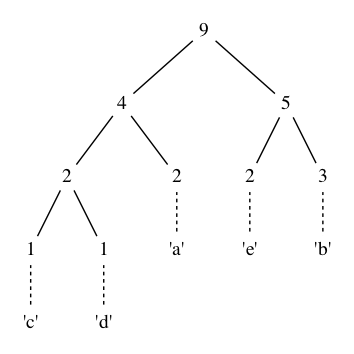

Original,Code
'a',01
'a',01
'b',11
'b',11
'b',11
'c',000
'd',001
'e',10
'e',10


In [24]:
table = "aabbbcdee"

simpleTree = huffmanTree table
simpleTree
buildHuffmanTable simpleTree table

Replacing the last bit in the first 'b' with a histogram would provide:

$$\epsilon = \frac{3-2}{3+2}$$

$\epsilon$-differential privacy. However, since it's from a subset of the database of size $5$, there are going to be $5$ differentially private queries on that subset. So, it would actually only provide:

$$\epsilon = \frac{1}{5^2}$$

$\epsilon$-differential privacy.

For every row in the database, we can replace one bit with its histogram representation: the equation above gives the privacy provided by replacing that bit. Obviously, the privacy provided by replacing later bits is much greater than that of earlier.

In [25]:
import Data.Ratio    ((%))
import Data.Function (on)

diffPrivacy :: Tree a -> Rational
diffPrivacy (Node i l r)
    = ((%) `on` toEnum) (abs (size l - size r)) (i * i)
diffPrivacy (Leaf _ _) = 0

<interactive>:1:16: error:
    • Expecting one more argument to ‘Tree a’
      Expected a type, but ‘Tree a’ has kind ‘* -> *’
    • In the type signature: diffPrivacy :: Tree a -> Rational

To use this for releasing private information, we will first need to have a way to generate a random bit from a histogram:

In [26]:
import System.Random       (RandomGen, randomR, getStdRandom)
import Control.Monad.State (StateT, state, runState, runStateT)
import Data.Bool           (bool)

choose :: (RandomGen g, Applicative m) => Int -> Int -> StateT g m Bool
choose f t = StateT (\g -> case randomR (1, f+t) g of
  (n,g') -> pure (f<n,g'))

getStdRandom (runState (replicateM 20 (bool '0' '1' <$> choose 1 1)))

"11011011011110010000"

Then, we'll need to be able to randomly choose an item from a histogram (represented as a tree):

In [27]:
select :: (RandomGen g, Monad m) => Tree a -> StateT g m a
select (Leaf _ x) = pure x
select (Node _ l r) = choose (size l) (size r)
                  >>= bool (select l) (select r)

<interactive>:1:37: error:
    • Expecting one more argument to ‘Tree a’
      Expected a type, but ‘Tree a’ has kind ‘* -> *’
    • In the type signature: select :: (RandomGen g, Monad m) => Tree a -> StateT g m a

In [28]:
import Data.Bool (bool)

subtrees :: [Bool] -> Tree a -> [Tree a]
subtrees = foldr f b where
  b = (:[])
  f side acc tr = tr : case tr of
    Leaf _ _ -> []
    Node _ l r -> acc (bool l r side)

last :: Foldable f => f a -> Maybe a
last = foldl (const Just) Nothing

diffAnonymize :: RandomGen g
              => Rational
              -> [Bool]
              -> Tree a
              -> Maybe (State g a)
diffAnonymize eps xs
    = fmap select
    . last
    . filter (\st -> diffPrivacy st > eps)
    . subtrees xs

randAnon :: (Ord a, RandomGen g) => Rational -> [a] -> Maybe (State g [a])
randAnon k xs = sequence <$> traverse (\x -> diffAnonymize k (mp Map.! x) tr) xs
  where
    tr = alphHuffmanTree xs
    mp = codeBook tr

import Statistics.Distribution.Normal
import System.Random.MWC
import Statistics.Distribution

randVar :: IO Double
randVar = withSystemRandom (genContVar (normalDistr 40 5) `asTypeOf`
                            const (undefined :: IO Double))

randAges <- filter (0<) <$> replicateM 100 randVar
anonRandAges <- getStdRandom (runState (fromJust (randAnon 0 randAges)))

randAges == anonRandAges

<interactive>:12:18: error:
    • Expecting one more argument to ‘Tree a’
      Expected a type, but ‘Tree a’ has kind ‘* -> *’
    • In the type signature: diffAnonymize :: RandomGen g => Rational -> [Bool] -> Tree a -> Maybe (State g a)
<interactive>:1:23: error:
    • Expecting one more argument to ‘Tree a’
      Expected a type, but ‘Tree a’ has kind ‘* -> *’
    • In the type signature: subtrees :: [Bool] -> Tree a -> [Tree a]
<interactive>:1:34: error:
    • Expecting one more argument to ‘Tree a’
      Expected a type, but ‘Tree a’ has kind ‘* -> *’
    • In the type signature: subtrees :: [Bool] -> Tree a -> [Tree a]

In [29]:
histogram 2 10 randAges
histogram 2 10 anonRandAges

<interactive>:1:16: error: Variable not in scope: randAges :: [Double]